### RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением.

### Часть I

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:<br>
➢	численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;<br>
➢	туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;<br>
➢	игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;<br>
➢	игрок может совершать одно из двух действий:<br>
○	hit  — взять ещё одну карту;<br>
○	stand — не брать больше карт;<br>
➢	если сумма очков у игрока на руках больше 21, он проигрывает (bust);<br>
➢	если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;<br>
➢	после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);<br>
➢	в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).<br>
Именно этот простейший вариант блекджека реализован в OpenAI Gym:<br>
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
1.	Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.<br>
2.	Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.<br>
3.	Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.<br>


In [4]:
# import blackjack

In [196]:
import gym
from gym import envs
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# print(envs.registry.all())

### Simple strategy

In [201]:
env=gym.make('Blackjack-v1', natural=True)

In [202]:
def simple_strategy_episode(env):
    """
    observations:
        score_player, score_dealer, usable_ace [natural blackjack]
    actions: 0 - stand, 1 - hit
    """
    obs, actions, rewards = [], [], []
    observation = env.reset()
    done = False
    while not done:
        score_player, score_dealer, usable_ace = observation
        action = 1 if score_player < 19 else 0
        actions.append(action)
        obs.append(observation)
        observation, reward, done, _ = env.step(action)
        rewards.append(reward)
    return obs, actions, rewards

In [194]:
def plot_mean_reward(reward_history):
    b = np.cumsum(reward_history)
    mean_reward = b/np.arange(1, b.shape[0] + 1)
    plt.plot(mean_reward)
    plt.xlabel('episode')
    plt.ylabel('mean reward')
    plt.grid()
    plt.show()

In [203]:
#Single example
obs, actions, rewards = simple_strategy_episode(env)
print(f"observations[score_player, score_dealer, usable_ace]={obs}, actions={actions}, rewards={rewards}" )

observations[score_player, score_dealer, usable_ace]=[(9, 2, False), (15, 2, False), (16, 2, False)], actions=[1, 1, 1], rewards=[0.0, 0.0, -1.0]


In [204]:
num_of_episodes = int(1e5)
simple_strategy_reward = 0
reward_history = []
for i in range(num_of_episodes): 
    _, _, rewards = simple_strategy_episode(env)
    simple_strategy_reward = (simple_strategy_reward * i + rewards[-1]) / (i + 1)
    reward_history.append(rewards[-1])

In [205]:
print(f"Reward for simple strategy is {simple_strategy_reward}")

Reward for simple strategy is -0.1940399999999984


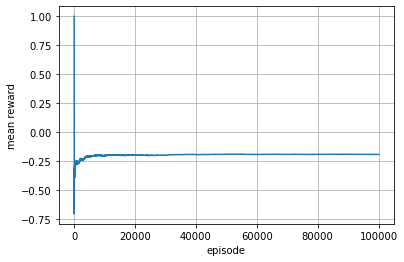

In [206]:
plot_mean_reward(reward_history)

In [207]:
env.close()

#### Reward for simple strategy is -0.196

### Q-learning

In [ ]:
env=gym.make('Blackjack-v1', natural=True)

In [93]:
def get_random_Q():
    # численные значения карт равны от 2 до 11 
    # в начале игры у игрока 2 карты, т.е. 2 очка минимум (туз+туз) и 21 максимум 
    
    # у дилера 2 карты, одна открыта - это от 1 до 10 (1 - это туз) P.S. почему не 11 (заранее не знаем, сколько стоит его туз?)
    # в конце игры у игрока максимум 32 очка при переборе: 21 без usable_ace + туз
    # невозможные состояния: 
    # 1) 32 с usable_ace; 
    # 2)очков меньше 13 с usable_ace (туз+2 минимум)    
        #-> по ходу, это не так, обнуляется только второй туз, а первый остается и может быть 11+1=12, значит
        # очков меньше 12 с usable_ace быть не может
    # Q-value: [hit, stand] reward
    #состояния >= 21 - игра закончена, done, final states

    player_Q_Values = {} 
    for player_val in range(2, 33):#max=21+ace
        for dealer_val in range(1, 11):
            for usable_ace in [True, False]:          
                if (player_val == 21) and not usable_ace:
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 1] #in case of hit we get 0, stand +1
                elif (player_val == 21) and usable_ace:
                    #natural_blackjack
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 1.5]
                elif (player_val == 32) and usable_ace:
                    continue                     
                elif (player_val < 12) and not usable_ace:
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = np.random.random(2)
                elif (player_val >= 12) and (player_val < 21):
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = np.random.random(2)            
                elif player_val > 21:    #i > 21
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 0]
    return player_Q_Values

In [86]:
def compute_policy_by_Q(player_Q_Values, gamma=1.0):
    pi = {}
    for key in player_Q_Values:
        pi[key] = np.argmax( player_Q_Values[key] )
    return pi

In [123]:
def extract_array_from_Q(Q):
    for k in Q.keys():
        arr.append(Q[k])
    arr = np.array(arr)
    return arr

In [149]:
def key_to_idx(Q):
    idx_dict = {}
    idx = 0
    for k in Q.keys():
        idx_dict[k] = idx
        idx += 1
    return idx_dict    

In [200]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9, nA=2):

    states, actions, rewards = [], [], []
    observation = env.reset()
    #observations is [score_player, score_dealer, usable_ace]    
    #nA = 2 # total numbber of possible actions
    s = observation
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)
    done = False
    
    while not done:
        observation, reward, done, _= env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(reward)
        s_prime = observation
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s, a = s_prime, a_prime
        
    return  states, actions, rewards    

### Test

In [158]:
Q = get_random_Q()
pi = compute_policy_by_Q(Q)
idxs = key_to_idx(Q)

In [161]:
Q_hist_Qlearn = [ ]
reward_history = []
Q_hist_Qlearn.append(extract_array_from_Q(Q))

num_of_episodes = 100
for _ in range(num_of_episodes):
    _, _, rewards = Q_learning_episode(env, pi, Q, nA=2)
    reward_history.append(rewards[-1])
    pi = compute_policy_by_Q(Q)
    Q_hist_Qlearn.append(np.copy(extract_array_from_Q(Q)))

### Подбор гиперпараметров 

In [165]:
eps_range = np.arange(0.1, 0.5, 0.1)
alpha_range = [0.00001, 0.0001, 0.001, 0.01]
gamma_range = [0.2, 0.4, 0.6, 0.8]

In [183]:
reward_history = []
num_of_episodes = int(1e5)

current_run = 1
for epsilon in eps_range:
    for alpha in alpha_range:
        for gamma in gamma_range:
            Q = get_random_Q()
            pi = compute_policy_by_Q(Q)
            episode_reward = 0
            for i in range(num_of_episodes):
                _, _, rewards = Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma, nA=2)
                pi = compute_policy_by_Q(Q)
                episode_reward = (episode_reward * i + rewards[-1]) / (i + 1)
            reward_history.append((epsilon, alpha, gamma, episode_reward))
            print(f"{current_run}: epsilon={epsilon}, alpha={alpha}, gamma={gamma}: avg_reward={episode_reward}")
            current_run += 1

1: epsilon=0.1, alpha=1e-05, gamma=0.2: avg_reward=-0.5134300000000004
2: epsilon=0.1, alpha=1e-05, gamma=0.4: avg_reward=-0.46216
3: epsilon=0.1, alpha=1e-05, gamma=0.6: avg_reward=-0.4439199999999981
4: epsilon=0.1, alpha=1e-05, gamma=0.8: avg_reward=-0.49005
5: epsilon=0.1, alpha=0.0001, gamma=0.2: avg_reward=-0.4105500000000002
6: epsilon=0.1, alpha=0.0001, gamma=0.4: avg_reward=-0.4348400000000003
7: epsilon=0.1, alpha=0.0001, gamma=0.6: avg_reward=-0.4422600000000007
8: epsilon=0.1, alpha=0.0001, gamma=0.8: avg_reward=-0.4926899999999998
9: epsilon=0.1, alpha=0.001, gamma=0.2: avg_reward=-0.31368000000000257
10: epsilon=0.1, alpha=0.001, gamma=0.4: avg_reward=-0.3191199999999977
11: epsilon=0.1, alpha=0.001, gamma=0.6: avg_reward=-0.3280900000000023
12: epsilon=0.1, alpha=0.001, gamma=0.8: avg_reward=-0.3150200000000003
13: epsilon=0.1, alpha=0.01, gamma=0.2: avg_reward=-0.1484899999999997
14: epsilon=0.1, alpha=0.01, gamma=0.4: avg_reward=-0.16823999999999892
15: epsilon=0.1, al

In [186]:
fin_history = np.array([np.array(item) for item in reward_history])

In [190]:
fin_history[:, 3].argmax()

12

In [191]:
fin_history[12]

array([ 0.1    ,  0.01   ,  0.2    , -0.14849])

#### Оптимальные параметры получились: epsilon=0.1, alpha=0.01, gamma=0.2

In [193]:
reward_history_v1 = []

Q = get_random_Q()
pi = compute_policy_by_Q(Q)

num_of_episodes = int(1e5)
for _ in range(num_of_episodes):
    _, _, rewards = Q_learning_episode(env, pi, Q, epsilon=0.1, alpha=0.01, gamma=0.2)
    reward_history_v1.append(rewards[-1])
    pi = compute_policy_by_Q(Q)

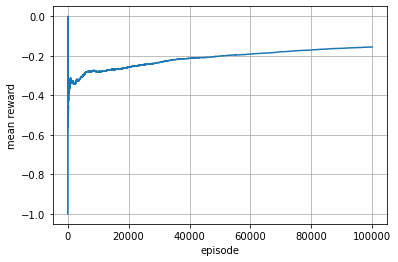

In [197]:
plot_mean_reward(reward_history_v1)

In [198]:
print(f"Reward for q learning is {np.mean(reward_history_v1)}")

Reward for q learning is -0.15548


In [199]:
env.close()

### Часть II

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:<br>
➢	double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.<br>
4.	Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.<br>
5.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.<br>

In [208]:
from blackjack import BlackjackDoubleEnv

In [209]:
env = BlackjackDoubleEnv(natural=True)

In [210]:
def get_random_Q_double():
    
    # добавляем в Q награды за третье действие double

    player_Q_Values = {} 
    for player_val in range(2, 33):
        for dealer_val in range(1, 11):
            for usable_ace in [True, False]:          
                if (player_val == 21) and not usable_ace:
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 1, 0] #in case of hit we get 0, stand +1, double is impossible
                elif (player_val == 21) and usable_ace:
                    #natural_blackjack
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 1.5, 0]
                elif (player_val == 32) and usable_ace:
                    continue                     
                elif (player_val < 12) and not usable_ace:
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = np.random.random(3)
                elif (player_val >= 12) and (player_val < 21):
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = np.random.random(3)            
                elif player_val > 21:    #i > 21
                    player_Q_Values[(player_val, dealer_val, usable_ace)] = [0, 0, 0]
    return player_Q_Values

In [212]:
reward_history = []

Q = get_random_Q_double()
pi = compute_policy_by_Q(Q)

num_of_episodes = int(1e5)
for _ in range(num_of_episodes):
    _, _, rewards = Q_learning_episode(env, pi, Q, epsilon=0.1, alpha=0.01, gamma=0.2, nA=3)
    reward_history.append(rewards[-1])
    pi = compute_policy_by_Q(Q)

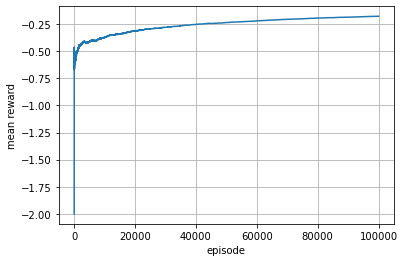

In [213]:
plot_mean_reward(reward_history)

In [214]:
print(f"Reward for q learning with doubling is {np.mean(reward_history)}")

Reward for q learning with doubling is -0.17897


In [219]:
env.close()

1: epsilon=0.1, alpha=0.01, gamma=0.1: avg_reward=-0.19089499999999907
2: epsilon=0.1, alpha=0.01, gamma=0.2: avg_reward=-0.18294999999999897
3: epsilon=0.1, alpha=0.01, gamma=0.4: avg_reward=-0.17812000000000047
4: epsilon=0.2, alpha=0.01, gamma=0.1: avg_reward=-0.1846049999999994
5: epsilon=0.2, alpha=0.01, gamma=0.2: avg_reward=-0.18906000000000023
6: epsilon=0.2, alpha=0.01, gamma=0.4: avg_reward=-0.17722999999999975
7: epsilon=0.2, alpha=0.01, gamma=0.6: avg_reward=-0.18427000000000007
8: epsilon=0.2, alpha=0.01, gamma=0.8: avg_reward=-0.17979500000000145
10: epsilon=0.2, alpha=0.001, gamma=0.4: avg_reward=-0.18282000000000043

### Часть III

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.<br>

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.<br>
6.	Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).<br>
7.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.<br>

In [217]:
from blackjack import BlackjackCountDoubleEnv

In [220]:
env = BlackjackCountDoubleEnv(natural=True)

In [ ]:
def get_random_Q_count():
    
    # добавляем в Q ключи, зависящие от текущего счета

    player_Q_Values = {} 
    for player_val in range(2, 33):
        for dealer_val in range(1, 11):
            for usable_ace in [True, False]:
                for count in np.arange(-20, 20, 0.5):
                    # вроде при таком подсчете самое минимальное, 
                    # что можно насчитать до перемешивания колоды, это -17 
                    #(сумма полной колоды 0, остались для перемешивания 15 карт, 
                    # из которых 4 карты веса 1.5 и 11 веса 1) 
                    # а максимальное - это 15 (выкинули 15 карт веса -1)
                    # беру с запасом на всякий случай
                    if (player_val == 21) and not usable_ace:
                        player_Q_Values[(player_val, dealer_val, usable_ace, count)] = [0, 1, 0] 
                        #in case of hit we get 0, stand +1, double is impossible
                    elif (player_val == 21) and usable_ace:
                        #natural_blackjack
                        player_Q_Values[(player_val, dealer_val, usable_ace, count)] = [0, 1.5, 0]
                    elif (player_val == 32) and usable_ace:
                        continue                     
                    elif (player_val < 12) and not usable_ace:
                        player_Q_Values[(player_val, dealer_val, usable_ace, count)] = np.random.random(3)
                    elif (player_val >= 12) and (player_val < 21):
                        player_Q_Values[(player_val, dealer_val, usable_ace, count)] = np.random.random(3)            
                    elif player_val > 21:    #i > 21
                        player_Q_Values[(player_val, dealer_val, usable_ace, count)] = [0, 0, 0]
    return player_Q_Values

In [226]:
reward_history = []

Q = get_random_Q_count()
pi = compute_policy_by_Q(Q)

num_of_episodes = int(1e5)
for i in range(num_of_episodes):
    print(i)
    _, _, rewards = Q_learning_episode(env, pi, Q, epsilon=0.1, alpha=0.01, gamma=0.2, nA=3)
    reward_history.append(rewards[-1])
    pi = compute_policy_by_Q(Q)

KeyboardInterrupt: 

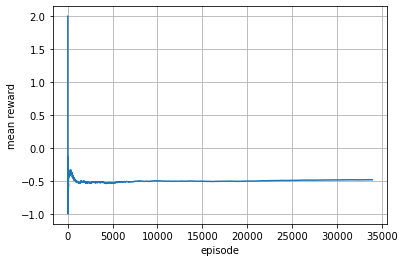

In [228]:
plot_mean_reward(reward_history)

In [229]:
print(f"Reward for q learning with doubling is {np.mean(reward_history)}")

Reward for q learning with doubling is -0.4814782070550791


In [ ]:
env.close()

### Итого: 
1) в среднем простая стратегия дает выигрыш -0.19404 <br>
2) q-обучение с подобранными гиперпараметрами (epsilon=0.1, alpha=0.01, gamma=0.2) дало -0.15548 <br>
3) q-обучение с опцией удвоения ставки и не подобранными гиперпараметрами (взяты из предыдущего пункта) -0.17897 <br>
4) q-обучение с удвоением ставки и подсчетом карт и не подобранными гиперпараметрами ...(TODO:finish calc) <br>

Обыграть казино не удалось. 
Возможно, если получше подобрать параметры для вариантов 3-4, они дадут улучшение

Notes

pi - стратегия <br>
s - состояние state  <br>
a - действие action  <br>
Value function:  <br>
V(s)= E_pi[Gt|St=s] - функция значений состояния [ожидаемый доход, который мы получим, если выйдем из состояния s и дальше будем действовать по стратегии pi] <br>
Q(s, a)= E_pi[Gt|St=s]  - функция значений пара значений состояние-действие [ожидаемый доход, который мы получим, если выйдем из состояния s, в s сделаем действие a и дальше будем действовать по стратегии pi] <br>

a_prime - действие на следующий ход, <br> 
np.max( Q[s_prime] ) - лучшее, что мы можем сделать в следующем состоянии